<a href="https://colab.research.google.com/github/VenkateshDas/TwitterTreasures/blob/main/twitter_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter tweets Analysis 
1. Data reading
2. Data cleaning 
3. Data Exploration and visualisation
 

## File paths 

In [ ]:
graph_output_file_path = "/content/drive/MyDrive/twitter_data/graphs/"
dataset_file_path = "/content/drive/MyDrive/twitter_data/armin_laschet_cdu_mixed_lang_tweets.csv"

## Install libraries

In [ ]:
!pip install palettable

In [ ]:
!pip install plotly

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 8.5MB/s 
     |████████████████████████████████| 890kB 34.4MB/s 
     |████████████████████████████████| 2.9MB 38.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f9771644b1b1dc22140e3068ef281ebf091cc3760fce76c1df225a27d36f1deb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Sentiment Analysis 

!pip install germansentiment

## Import necessary libraries and assign basic variables

In [ ]:
import pandas as pd
import re 
import os
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from germansentiment import SentimentModel
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import random
import ast
from collections import Counter
from palettable.colorbrewer.qualitative import Dark2_8
from palettable import cubehelix
from matplotlib import cm

nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')

german_stop_words = stopwords.words('german')
english_stop_word = stopwords.words('english')
stopwords = german_stop_words + english_stop_word

matplotlib.rc("savefig", dpi=200)
plt.rcParams.update({'font.size': 25})

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from transformers import *
sentiment = pipeline('sentiment-analysis') # For english

# Read File 

In [ ]:
def read_tweets_csv(file_path):
    file_path = dataset_file_path
    df=pd.read_csv(file_path)
    df.drop(["Unnamed: 0"],axis=1,inplace=True)
    df['date']=pd.to_datetime(df['date'])
    return df

In [ ]:
political_df = read_tweets_csv(dataset_file_path)
political_df.head()

id  ...                                           hashtags
0  1351473540839702533  ...                            ['Laschet', 'Lockdown']
1  1351473477396606977  ...                                                 []
2  1351473440256102401  ...                                                 []
3  1351473406588428292  ...                              ['ltnrw', 'Adenauer']
4  1351473266813239298  ...  ['Laschet', 'SterbenmitLaschet', 'KeinSterbenM...

[5 rows x 14 columns]

# Data Cleaning

In [ ]:
def extract_hashtag(input_text):
    hashtags = re.findall(r'#[\w]*',input_text)
    return hashtags

def extract_username(input_text):
    usernames = re.findall(r"@[\w]*",input_text)
    return usernames

def remove_urls(s):
    # re.sub(pattern,repl,string) is used to replace substrings. Will replace the matches in string with repl
    return re.sub(r'https?://\S+', "", s)

def clean_txt(input_text):

    if type(input_text) != str:
        return input_text 
    #removing hashtags,emojis,stopwords
    input_text=re.sub(r'#[\w]*','',input_text)
    input_text=input_text.encode("ascii","ignore")
    input_text=input_text.decode()
    input_text = remove_urls(input_text)
    
    ##removing @user
    r = re.findall(r'@[\w]*', input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
   
    #removing stopwords    
    input_text = ' '.join([i for i in wordpunct_tokenize(input_text.lower()) if not i in stopwords])

    #removing punctuation,numbers and whitespace   
    result=re.sub(r'[^\w\s]', '', input_text.lower())
    result=re.sub('\s+',' ',result)
    ##removing links
    rresultes=re.sub(r'https[\w]*', '', result, flags=re.MULTILINE)
    #removing digits
    result=''.join(i for i in result if not i.isdigit())
    
    return result

In [ ]:
political_df['Mentioned_Hashtags'] = political_df['text'].apply(extract_hashtag) #To extract the hashtags if it was missed during the scraping. 
political_df['Mentioned_Usernames'] = political_df['text'].apply(extract_username)
political_df['Clean Tweet']=political_df['text'].apply(clean_txt)
political_df['Clean Description'] = political_df['description'].apply(clean_txt)

In [ ]:
political_df.head()

id  ...                                  Clean Description
0  1351473540839702533  ...  querdenker schon anne frank vergleichen msst b...
1  1351473477396606977  ...                                        ehrlichkeit
2  1351473440256102401  ...                               sehnsucht demokratie
3  1351473406588428292  ...   abgeordnete vertreten themen anliegen cdu twi...
4  1351473266813239298  ...                   ber gefhrdung kindeswohls schule

[5 rows x 18 columns]

# Exploratory Data Analysis

### Tweets Source

In [ ]:
def plot_countplots(y_value,data_df,x_counts,title,output_file):    
    sns.set()
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    g=sns.countplot(y=y_value,  data=data_df,order=x_counts)
    plt.title(title)
    plt.savefig(output_file)
    plt.show()

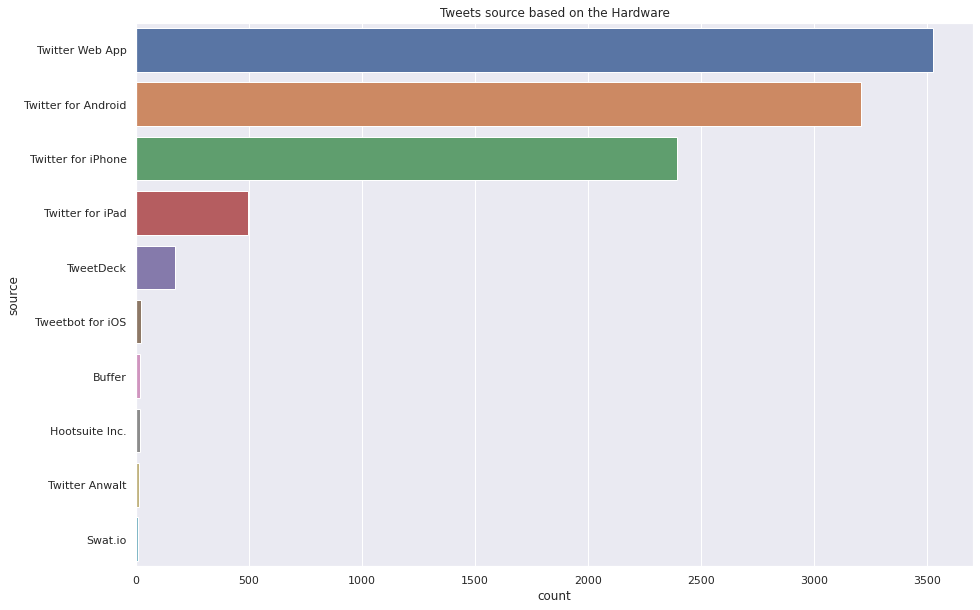

In [ ]:
plot_countplots("source",political_df,political_df['source'].value_counts().iloc[:10].index,"Tweets source based on the Hardware",graph_output_file_path+"/sources.png")

### Location 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127464 missing from current font.
  fon

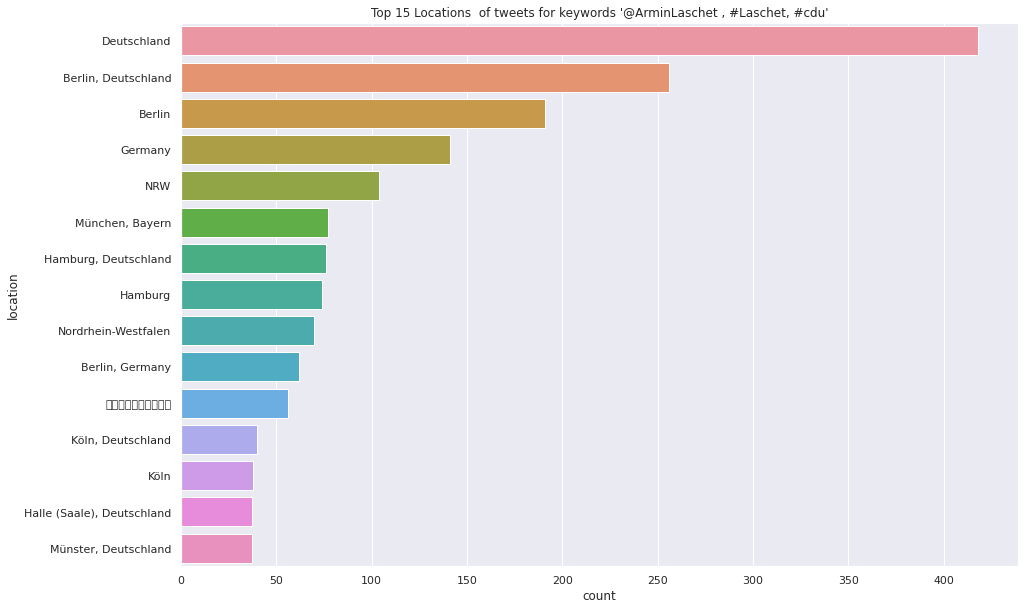

In [ ]:
plot_countplots("location",political_df,political_df['location'].value_counts().iloc[:15].index,"Top 15 Locations  of tweets for keywords '@ArminLaschet , #Laschet, #cdu'",graph_output_file_path+"locations.png")

### Language 

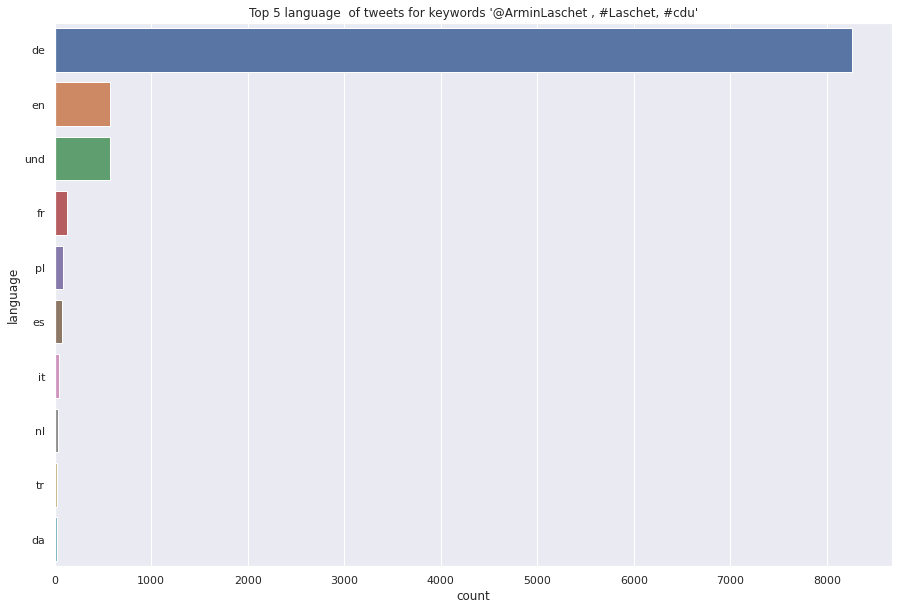

In [ ]:
plot_countplots("language",political_df,political_df['language'].value_counts().iloc[:10].index,"Top 5 language  of tweets for keywords '@ArminLaschet , #Laschet, #cdu'",graph_output_file_path+"languages.png")

## Wordclouds

In [ ]:
localtion_list = list(political_df['location'].value_counts().iloc[:100].index)
source_list = list(political_df['source'].value_counts().iloc[:10].index)
languages_list = list(political_df['language'].value_counts().iloc[:20].index)

In [ ]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def color_dark28(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Dark2_8.colors[random.randint(0,7)])

def color_cubehelix(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(cubehelix.perceptual_rainbow_16_r.colors[random.randint(0,7)])

def masked_worldcloud_generate(list_data,file_path,save_file_path,font_path,background,title,color='None'):
    wcloud=' '.join([i for i in list_data if type(i) == str])
    icon = Image.open(file_path)
    mask = Image.new("RGB", icon.size, (255,255,255))
    mask.paste(icon,icon)
    mask = np.array(mask)
    wordcloud = WordCloud(random_state=42, max_font_size=500,font_path=font_path,mask=mask,background_color=background,stopwords=stopwords,repeat=False).generate(wcloud)
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[15,10])
    if color != None:
        plt.imshow(wordcloud.recolor(color_func=color, random_state=3))
    elif color == 'None' :
        plt.imshow(wordcloud, interpolation="bilinear")
    # plt.title(title)
    plt.axis('off')
    plt.savefig(save_file_path)
    plt.show()

def worldcloud_generate(list_data,save_file_path,background,title,font_path,color):
    wcloud=' '.join([i for i in list_data if type(i) == str])
    wordcloud = WordCloud(random_state=42, max_font_size=300,background_color=background,font_path=font_path,color_func=color,repeat=False,stopwords=stopwords,relative_scaling='auto').generate(wcloud)
    plt.figure(figsize=[12,8])
    plt.imshow(wordcloud)
    # plt.title(title)
    plt.axis('off')
    plt.savefig(save_file_path)
    plt.show()

### Location, Source , Language wordclouds

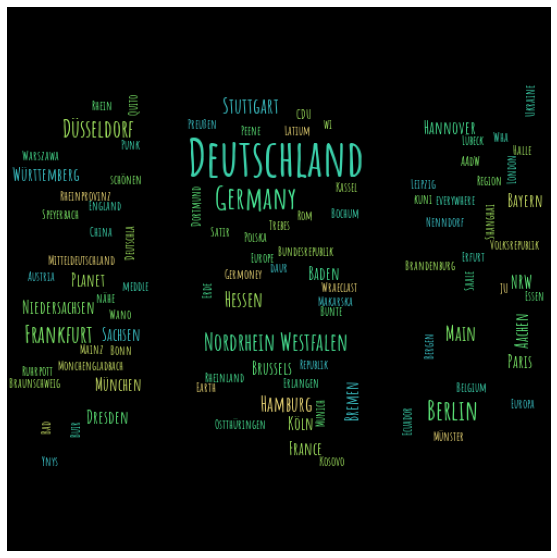

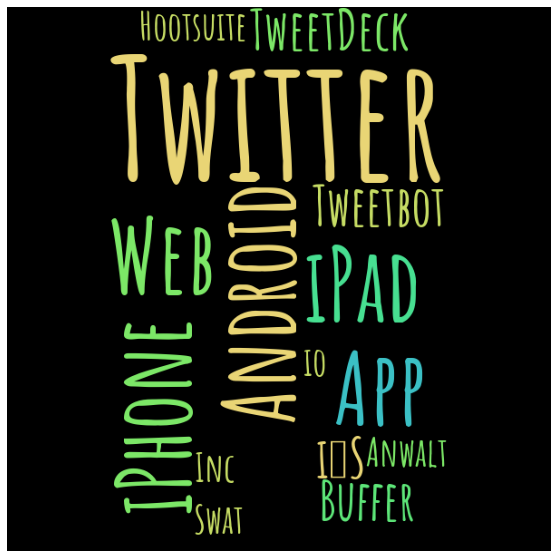

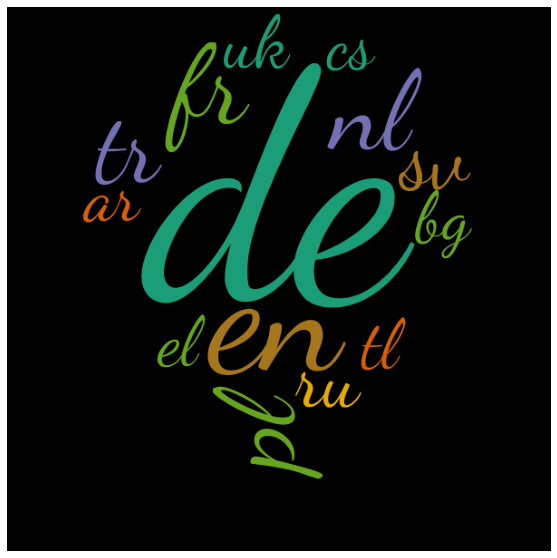

In [ ]:
masked_worldcloud_generate(list_data = localtion_list,file_path='/content/drive/MyDrive/twitter_data/icons/map-solid.png',save_file_path= graph_output_file_path +'location_wcloud_masked.png',font_path='/content/drive/MyDrive/twitter_data/font/AmaticSC-Bold.ttf', background='black',title='Location Wordcloud for Armin Laschet , CDU tweets',color= color_cubehelix)
masked_worldcloud_generate(list_data = source_list,file_path='/content/drive/MyDrive/twitter_data/icons/mobile-solid.png',save_file_path = graph_output_file_path +'source_wcloud.png',background='black',font_path ='/content/drive/MyDrive/twitter_data/font/AmaticSC-Bold.ttf',title='Source Wordcloud for Armin Laschet , CDU tweets',color=color_cubehelix)
masked_worldcloud_generate(list_data = languages_list,file_path='/content/drive/MyDrive/twitter_data/icons/map-marker-solid.png',save_file_path = graph_output_file_path +'language_wcloud.png',background='black',title = 'Language Wordcloud for Armin Laschet , CDU tweets',font_path='/content/drive/MyDrive/twitter_data/font/DancingScript-VariableFont_wght.ttf',color=color_dark28)

### Tweets wordcloud 
1. Masked 
2. Unmasked

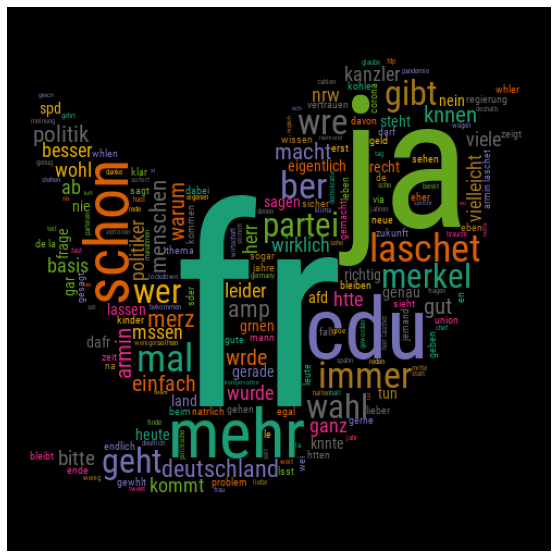

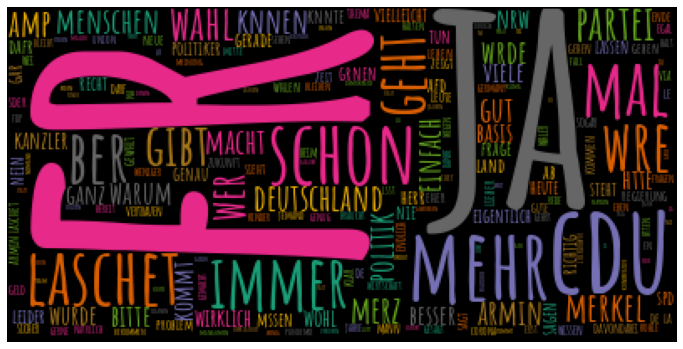

In [ ]:
masked_worldcloud_generate(list_data = political_df['Clean Tweet'],file_path='/content/drive/MyDrive/twitter_data/icons/twitter-brands.png',save_file_path=graph_output_file_path+'tweet_wcloud.png',background='black',color=color_dark28,title='Wordcloud for Tweets on Armin Laschet and CDU',font_path='/content/drive/MyDrive/twitter_data/font/RobotoCondensed-Regular.ttf')
worldcloud_generate(list_data = political_df['Clean Tweet'],save_file_path= graph_output_file_path+'tweet_wcloud_unmasked.png',background='black',title='Wordcloud for Tweets on Armin Laschet and CDU',font_path="/content/drive/MyDrive/twitter_data/font/AmaticSC-Bold.ttf",color=color_dark28)

### User description wordcloud
1. Masked 
2. Unmasked

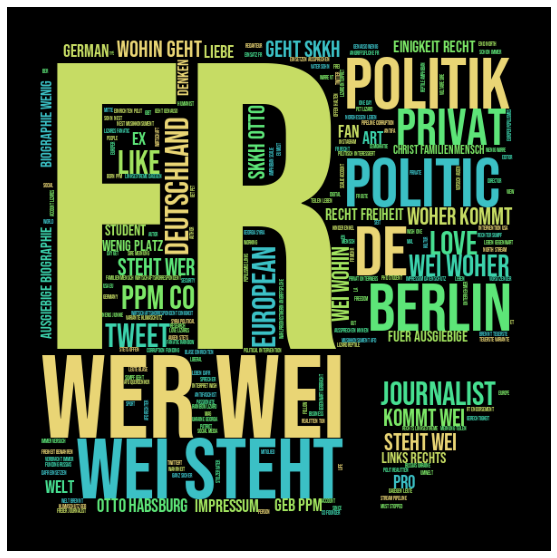

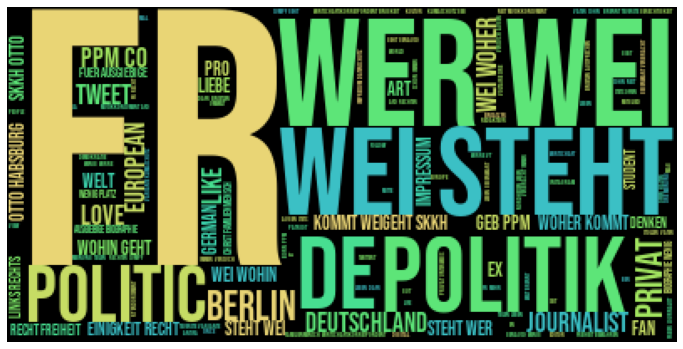

In [ ]:
masked_worldcloud_generate(list_data = political_df['Clean Description'],file_path='/content/drive/MyDrive/twitter_data/icons/sticky-note-solid.png',save_file_path=graph_output_file_path+'tweet_desc_wcloud.png',background='black',color=color_cubehelix,title='Wordcloud for Tweets Description on Armin Laschet and CDU',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf')
worldcloud_generate(list_data = political_df['Clean Description'],save_file_path= graph_output_file_path+'tweet_desc_wcloud_unmasked.png',background='black',title='Wordcloud for Tweets Description on Armin Laschet and CDU',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf',color = color_cubehelix)

## N-Gram Analysis 
1. Unigram
2. Bigram 
3. Trigram  

In [ ]:
# Frequency distribution of all Articles
def unigram_analysis(df,data,title,save_file_path):
    total_words_list = []
    for i in range(df.shape[0]):
        if type(data.iloc[i]) == str:
            for word in wordpunct_tokenize(data.iloc[i]):
                total_words_list.append(word)
    fdist = FreqDist(total_words_list)
    fig = plt.figure(figsize = (15,8))
    fd = fdist.plot(50,cumulative=False,color='red',title = title)
    plt.show()
    fig.savefig(save_file_path, bbox_inches = "tight")

def create_ngrams(sentences, n):
    ngrams_list = []
    for sentence in sentences:
        if type(sentence) == str :
            grams = list(ngrams(wordpunct_tokenize(sentence),n))
        ngrams_list.append(grams)
    return ngrams_list


def ngram_counter(ngram_list):

    total_ngrams_list = []
    for ngram in ngram_list:
        for gram in ngram:
            total_ngrams_list.append(gram)
    ngram_counter = Counter(total_ngrams_list)

    return total_ngrams_list,ngram_counter


def combine_ngrams(ngram_list):    
    total_combined_ngram_list = []
    for ngrams in ngram_list:
        combined_ngram_list = []
        for ngram in ngrams :
            combined_ngram_list.append('_'.join(str(v) for v in ngram))
        total_combined_ngram_list.append(combined_ngram_list)
    return total_combined_ngram_list

### Tweets - Unigram

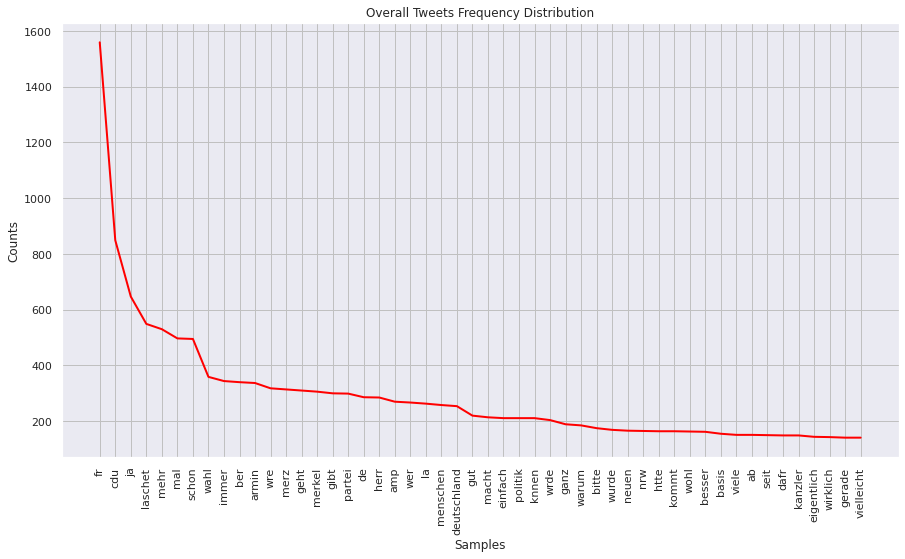

In [ ]:
unigram_analysis(political_df,political_df['Clean Tweet'],'Overall Tweets Frequency Distribution',graph_output_file_path + 'overall_tweet_freq_dist.png')

### User description - Unigram 

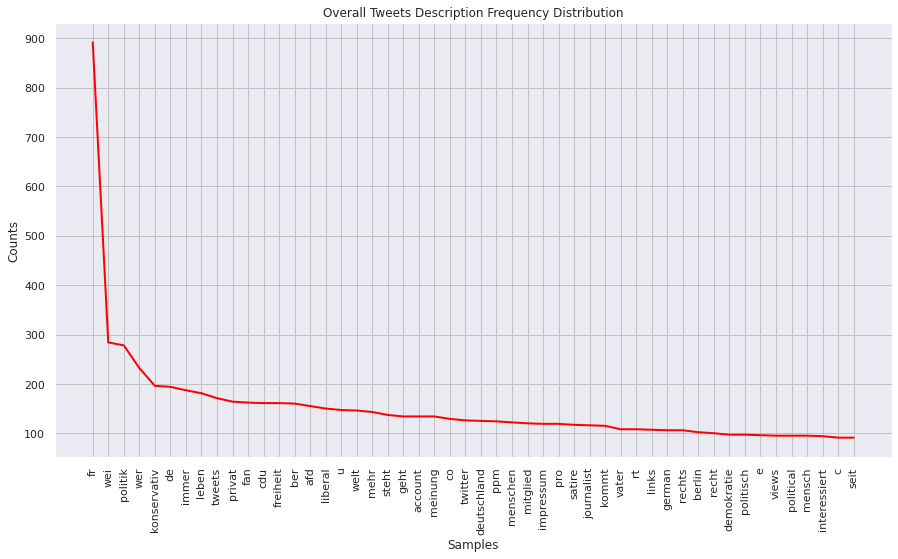

In [ ]:
unigram_analysis(political_df,political_df['Clean Description'],'Overall Tweets Description Frequency Distribution',graph_output_file_path + 'overall_tweet_desc_freq_dist.png')

### Bigrams , Trigrams 

In [ ]:
def plot_bigrams(data,title,save_file_path,most_common_n):
    color = cm.winter_r(np.linspace(0.5,0.2,20))
    bigram_list = create_ngrams(data, 2)
    total_bigrams_list , bigram_counter = ngram_counter(bigram_list)
    most_used_bigram = bigram_counter.most_common(most_common_n)
    most_used_bigram = dict(most_used_bigram)
    bigrams_series = pd.Series(most_used_bigram)
    fig_bigram = bigrams_series.sort_values().plot.barh(color= color, width= 1 , figsize=(20, 15),legend=True)
    fig_bigram.set_title(title,fontdict={'fontsize':30})
    fig_bigram.set_ylabel('Bigrams',fontdict={'fontsize':24})
    fig_bigram.set_xlabel('Counts',fontdict={'fontsize':24})
    fig_bigram.figure.savefig(save_file_path)
    plt.show()

def plot_trigrams(data,title,save_file_path,most_common_n):
    color = cm.coolwarm(np.linspace(0.1,0.2 , 20))
    trigram_list = create_ngrams(data, 3)
    total_trigrams_list , trigram_counter= ngram_counter(trigram_list)
    most_used_trigram= trigram_counter.most_common(most_common_n)
    most_used_trigram = dict(most_used_trigram)
    trigrams_series = pd.Series(most_used_trigram)
    fig_trigram = trigrams_series.sort_values().plot.barh(color=color, width= 1 , figsize=(20, 15),legend=True)
    fig_trigram.set_title(title,fontdict={'fontsize':30})
    fig_trigram.set_ylabel('Trigrams',fontdict={'fontsize':24})
    fig_trigram.set_xlabel('Counts',fontdict={'fontsize':24})
    fig_trigram.figure.savefig(save_file_path)
    plt.show()

#### Tweets and User description bigrams

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration


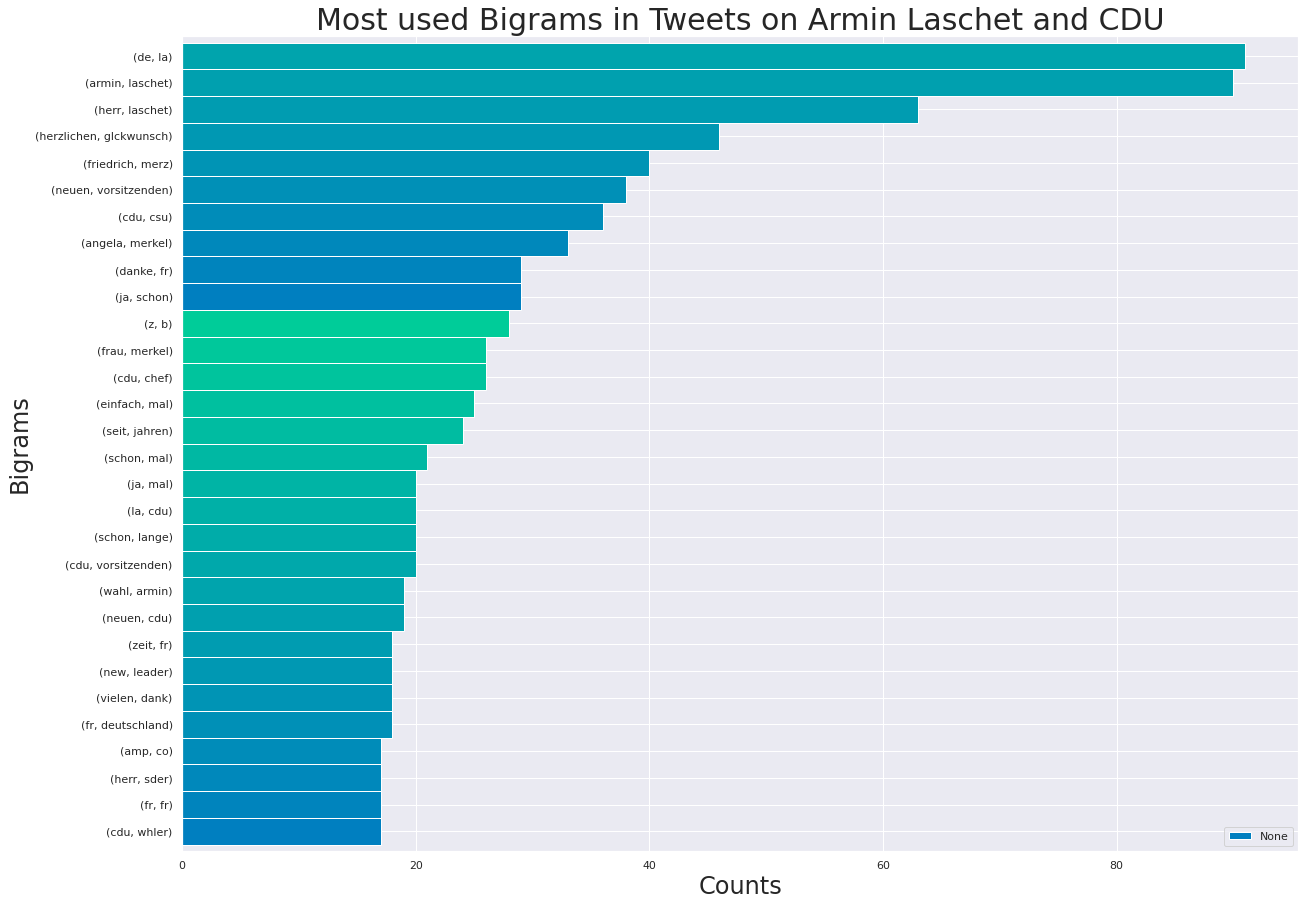

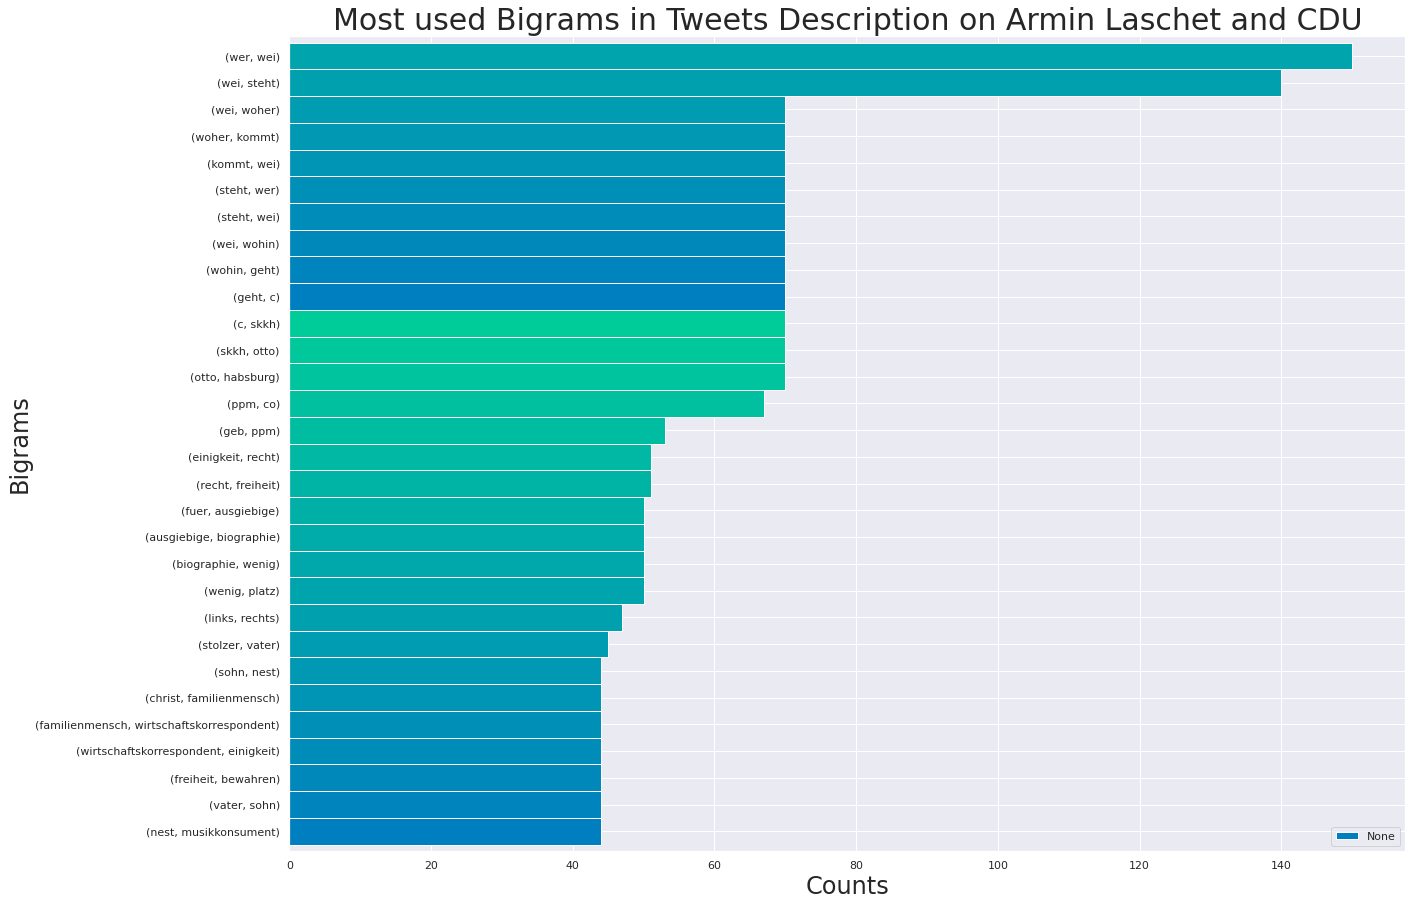

In [ ]:
plot_bigrams(political_df['Clean Tweet'],'Most used Bigrams in Tweets on Armin Laschet and CDU',graph_output_file_path+'tweet_bigram.png',most_common_n=30)
plot_bigrams(political_df['Clean Description'],'Most used Bigrams in Tweets Description on Armin Laschet and CDU',graph_output_file_path+'tweet_desc_bigram.png',most_common_n=30)

#### Tweets and User description trigrams

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration


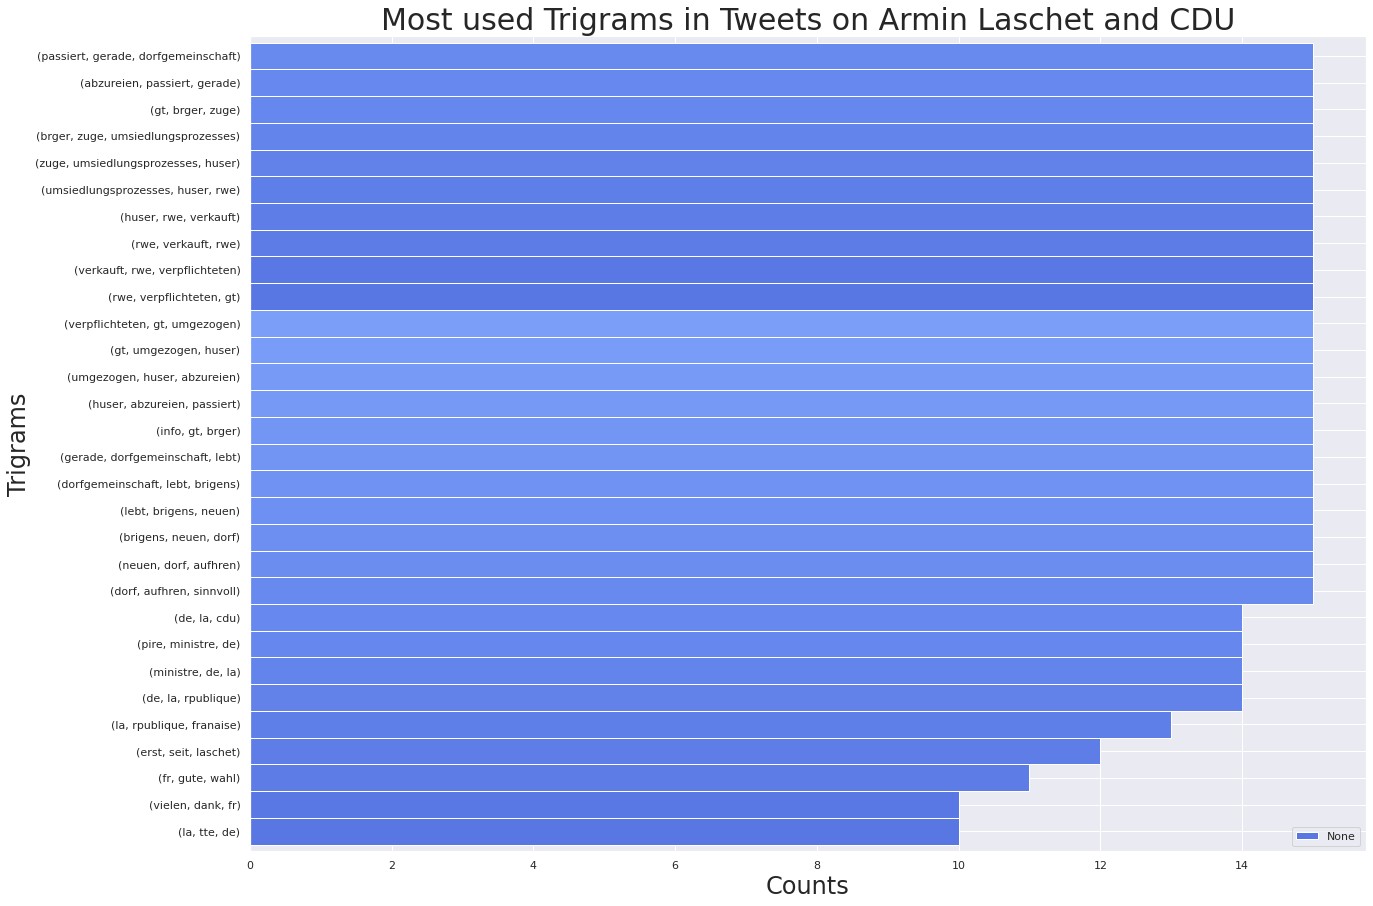

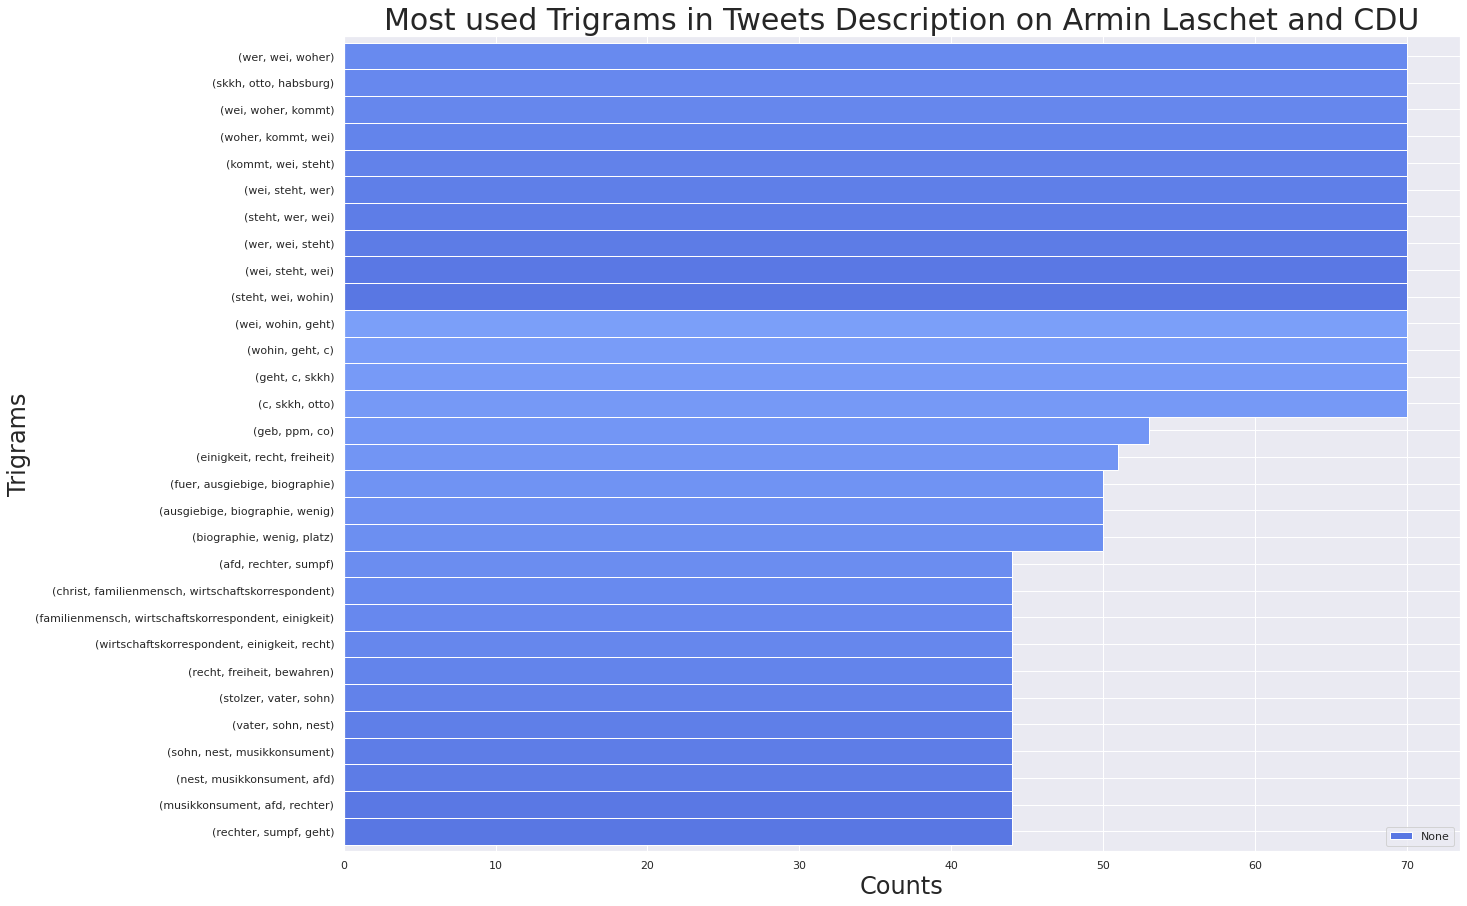

In [ ]:
plot_trigrams(political_df['Clean Tweet'],'Most used Trigrams in Tweets on Armin Laschet and CDU',graph_output_file_path+'tweet_trigram.png',most_common_n=30)
plot_trigrams(political_df['Clean Description'],'Most used Trigrams in Tweets Description on Armin Laschet and CDU',graph_output_file_path+'tweet_desc_trigram.png',most_common_n=30)

## Sentiment Analysis
1. German language sentiment analysis (Transformer model)
2. English language sentiment analysis (Transformer model)

In [ ]:
def write_read_pickle(mode,file_path,object=None):
    if mode == 'write':
        with open(file_path,'wb') as f:
            pickle.dump(object,f)
    elif mode == 'read':
        with open(file_path,'rb') as f:
            data = pickle.load(f)
        return data


### German sentiment Analysis

In [ ]:
def divide_chunks(l, n): 
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

def german_sentiment_analysis(data,chunks):

    clean_tweets_list = []
    sentiments = []
    model = SentimentModel()
    # This library needs input in the form of a list
    for i in range(data.shape[0]):
        clean_tweets_list.append(data.iloc[i])
    # How many elements each 
    # list should have 
    data_list = list(divide_chunks(clean_tweets_list,chunks)) 
    for i in range(len(data_list)):
        print("Chunk Number : {}".format(i))
        sentiment_list = model.predict_sentiment(data_list[i])
        sentiments.append(sentiment_list)
        del sentiment_list

    sentiment_list = []
    for sentiment_chunk in sentiments : 
        for sentiment in sentiment_chunk:
            sentiment_list.append(sentiment)

    return sentiment_list

In [ ]:
sentiments = write_read_pickle(mode='read',file_path='/content/drive/MyDrive/twitter_data/german_tweets_sentiment.pkl',object=None)
sentiment_list = []
for sentiment_chunk in sentiments : 
    for sentiment in sentiment_chunk:
        sentiment_list.append(sentiment)

In [ ]:
# political_df['sentiment']=german_sentiment_analysis(political_df['Clean Tweet'],100)
political_df['sentiment']=sentiment_list


### Sentiment count plot

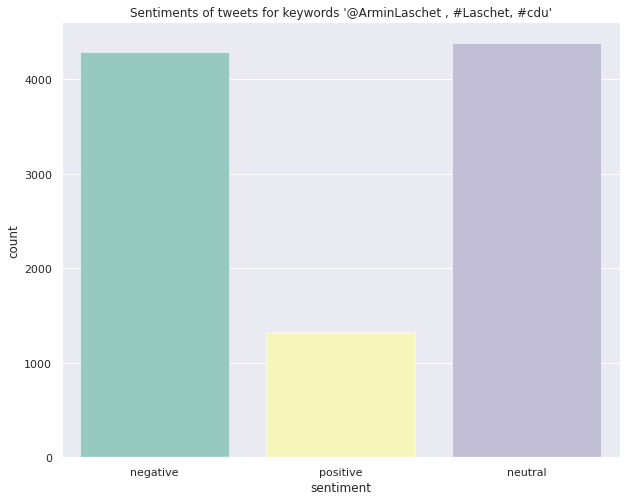

In [ ]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.countplot(x = political_df['sentiment'],palette="Set3",linewidth = 0.5)
plt.title("Sentiments of tweets for keywords '@ArminLaschet , #Laschet, #cdu'")
plt.show()


In [ ]:
pos=[]
neg=[]
neu = []
for _,row in political_df.iterrows():
    if(row['sentiment']=="positive"):
        pos.append(row['Clean Tweet'])
    elif(row['sentiment']=="negative"):
        neg.append(row['Clean Tweet'])
    elif(row['sentiment']=="neutral"):
        neu.append(row['Clean Tweet'])

### Sentiment wordcloud

#### Positive Wordcloud
1. Masked 
2. Unmasked

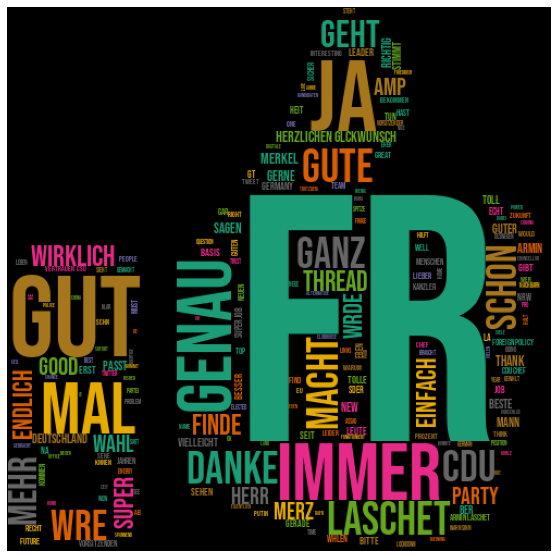

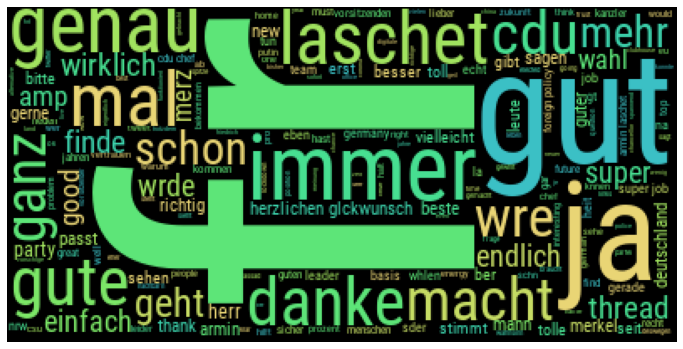

In [ ]:
masked_worldcloud_generate(list_data = pos,file_path='/content/drive/MyDrive/twitter_data/icons/thumbs-up-solid.png',save_file_path=graph_output_file_path+'positive_masked_cloud.png',background='black',color=color_dark28,title='Positive sentiment word cloud on tweets',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf')
worldcloud_generate(list_data = pos,save_file_path= graph_output_file_path+'positive_wcloud_unmasked.png',background='black',title='Positive sentiment word cloud on tweets',font_path='/content/drive/MyDrive/twitter_data/font/RobotoCondensed-Regular.ttf',color = color_cubehelix)
# masked_worldcloud_generate(pos,'/content/drive/MyDrive/twitter_data/Image/smile.jpg','./positive_masked_cloud.png')


#### Negative wordcloud - Masked

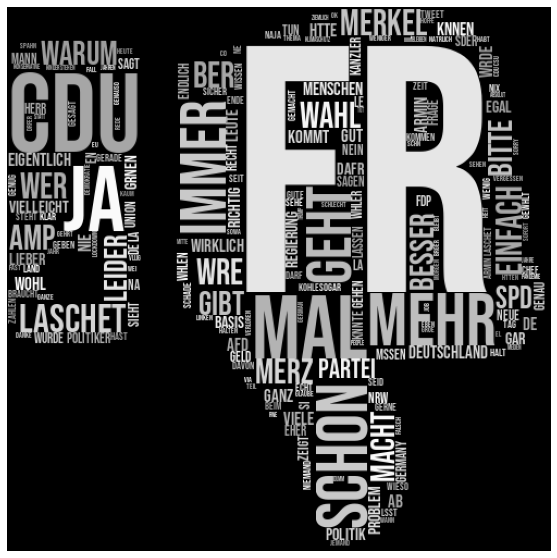

In [ ]:
masked_worldcloud_generate(list_data = neg,file_path='/content/drive/MyDrive/twitter_data/icons/thumbs-down-solid.png',save_file_path=graph_output_file_path+'negative_masked_cloud.png',background='black',color=grey_color_func,title='Negative sentiment word cloud on tweets',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf')

#### Neutral Wordcloud - Masked

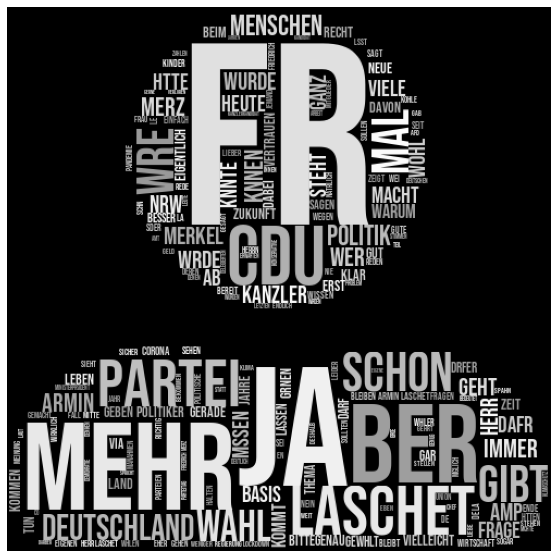

In [ ]:
masked_worldcloud_generate(list_data = neu,file_path='/content/drive/MyDrive/twitter_data/icons/user-alt-solid.png',save_file_path=graph_output_file_path+'neutral_masked_cloud.png',background='black',color=grey_color_func,title='Neutral sentiment word cloud on tweets',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf')

#### Sentiments on the given dates

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


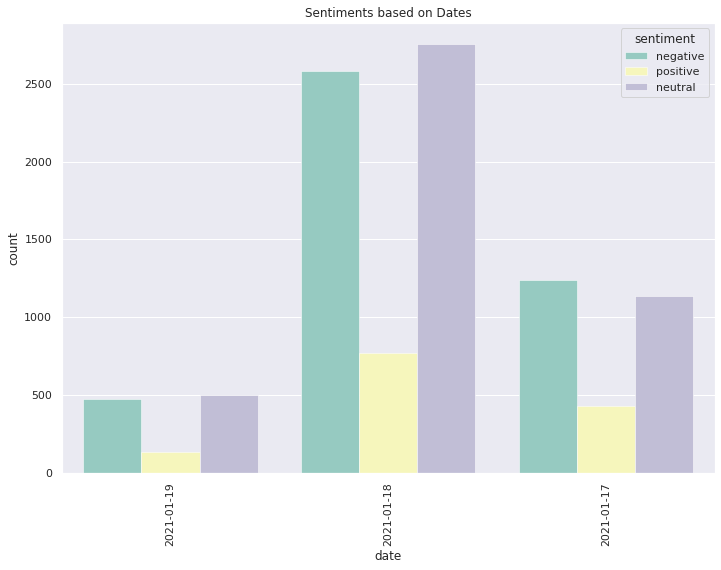

In [ ]:
# Date based sentiments

def sentiments_on_dates(df,title,save_file_path):
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    g=sns.countplot(df['date'].dt.date,hue=df['sentiment'],palette="Set3",linewidth = 0.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(save_file_path)
    plt.show()

sentiments_on_dates(political_df,'Sentiments based on Dates',graph_output_file_path+"date_sentiment.png")

### Hashtags and Username analysis

In [ ]:
def list_hashtags_usernames(df):
    hashtags = df['Mentioned_Hashtags']
    usernames = df['Mentioned_Usernames']

    HT_list = sum(list(hashtags),[])
    UN_list = sum(list(usernames),[])

    return HT_list,UN_list

In [ ]:
HT_list, UN_list = list_hashtags_usernames(political_df)

#### Hashtag wordcloud

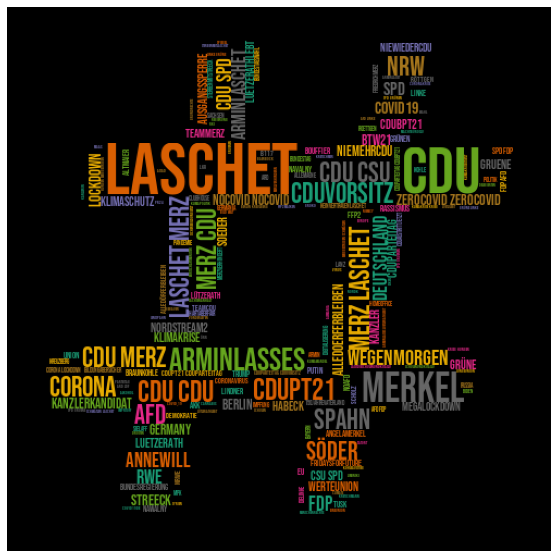

In [ ]:
masked_worldcloud_generate(list_data = HT_list,file_path='/content/drive/MyDrive/twitter_data/icons/hashtag-solid.png',save_file_path=graph_output_file_path+'hashtag_masked_cloud.png',background='black',color=color_dark28,title='Word cloud for Hashtags used in tweets',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf')

#### Username wordcloud

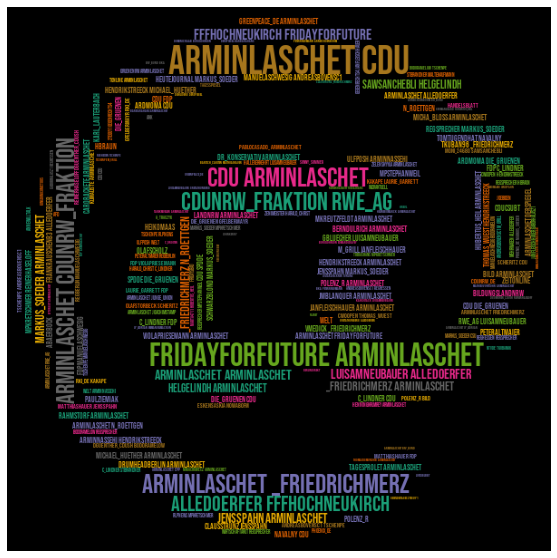

In [ ]:
masked_worldcloud_generate(list_data = UN_list,file_path='/content/drive/MyDrive/twitter_data/icons/at-solid.png',save_file_path=graph_output_file_path+'username_masked_cloud.png',background='black',color=color_dark28,title='Word cloud for Usernames used in tweets',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf')

### Visualise hashtags and usernames on sentiments

In [ ]:
def sentiment_hashtags_usernames(df):

    sentiment_df = df.groupby('sentiment')
    positive_df = sentiment_df.get_group('positive')
    negative_df = sentiment_df.get_group('negative')
    neutral_df = sentiment_df.get_group('neutral')

    hashtags_positive = positive_df['Mentioned_Hashtags']
    hashtags_negative = negative_df['Mentioned_Hashtags']
    hashtags_neutral = neutral_df['Mentioned_Hashtags']
    HT_positive = sum(list(hashtags_positive),[])
    HT_negative = sum(list(hashtags_negative),[])
    HT_neutral = sum(list(hashtags_neutral),[])

    usernames_positive = positive_df['Mentioned_Usernames']
    usernames_negative = negative_df['Mentioned_Usernames']
    usernames_neutral = neutral_df['Mentioned_Usernames']
    UN_positive = sum(list(usernames_positive),[])
    UN_negative = sum(list(usernames_negative),[])
    UN_neutral = sum(list(usernames_neutral),[])

    positive_retweets = positive_df['retweetcount']
    negative_retweets = negative_df['retweetcount']
    neutral_retweets = neutral_df['retweetcount']


    return HT_positive,HT_negative,HT_neutral,UN_positive,UN_negative,UN_neutral,positive_retweets,negative_retweets, neutral_retweets   


#### Hahstags , Usernames , retweets

In [ ]:
HT_positive,HT_negative,HT_neutral,UN_positive,UN_negative,UN_neutral,positive_retweets,negative_retweets, neutral_retweets = sentiment_hashtags_usernames(political_df)

In [ ]:
def plot_hash_user_count(all,positive,neutral,negative,common,save_file_path,title):
    color = cm.winter_r(np.linspace(0.5,0.2,20))
    hashtag_count_dict = {'Total ' : len(all),
                          'Positive ' : len(positive),
                          'Neutral ' : len(neutral),
                          'Negative ' : len(negative),
                          'Common ' : len(common)}
    plt.figure(figsize=(10,8))
    lists = sorted(hashtag_count_dict.items(),reverse = True) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.bar(x, y,color = color,width=0.5)  
    plt.xticks(rotation = 45,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title,fontdict={'fontsize':22})
    plt.ylabel('Counts',fontdict={'fontsize':22})
    plt.xlabel('Values',fontdict={'fontsize':22})

    for i, v in enumerate(y):
        plt.text(i-0.15,v/y[i]+600 , y[i], color='white', fontsize = 12)

    plt.savefig(save_file_path)
    plt.show()

In [ ]:
def plot_freq_dist(list_data,title,save_file_path,n):
    a = nltk.FreqDist(list_data)
    d = pd.DataFrame({'Key': list(a.keys()),
                    'Value': list(a.values())})
    # selecting top 10 most frequent hashtags     
    d = d.nlargest(columns="Value", n = n) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x= "Key", y = "Value")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(save_file_path)
    plt.show()

#### Hashtags - Positive, Neutral, Negative, Common hashtag 
1. Top 20 Hashtags 
- Overall
- Positive
- Neutral 
- Negative
2. Hashtag counts plot
3. Common hashtags wordcloud

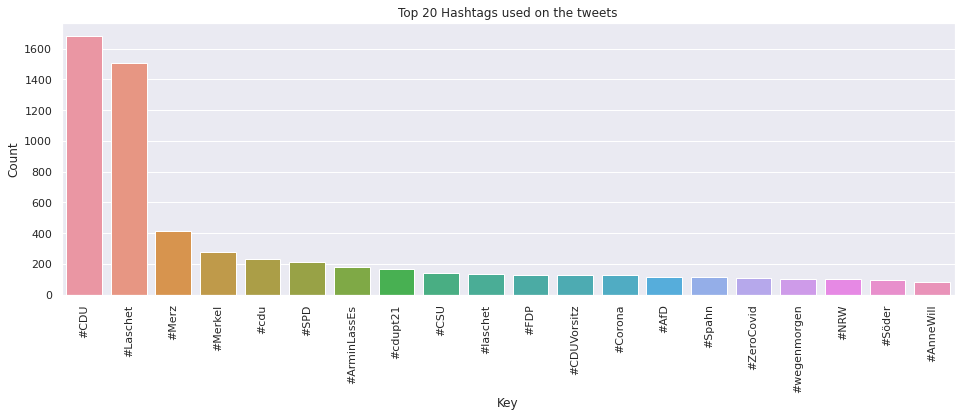

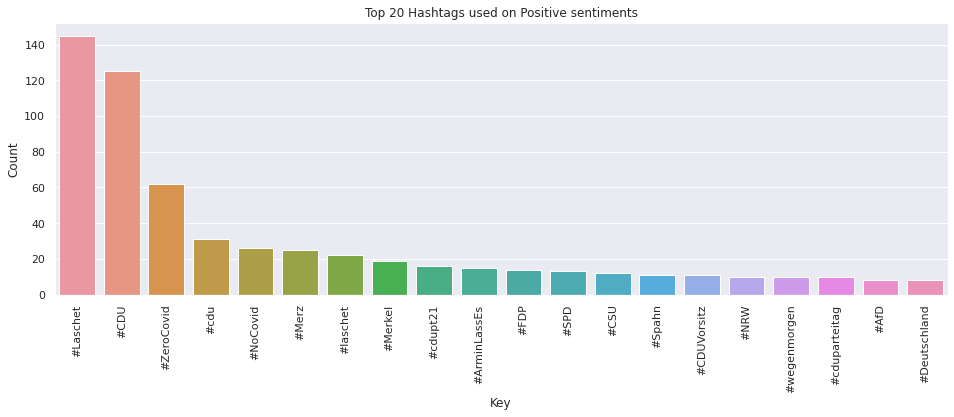

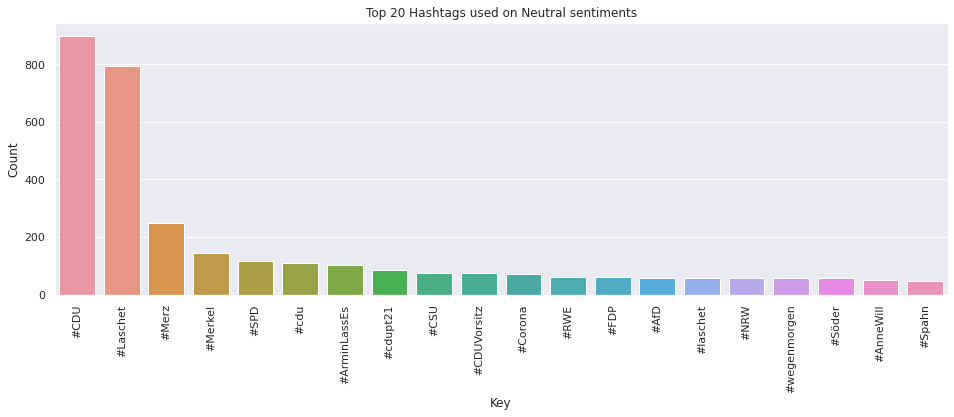

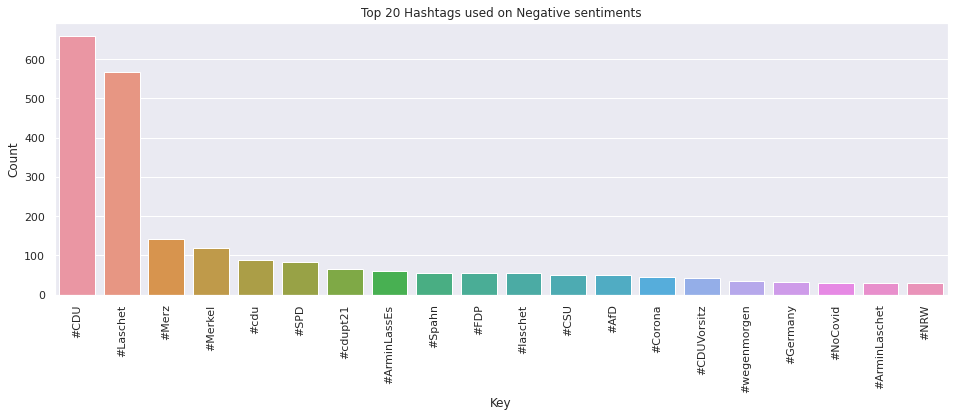

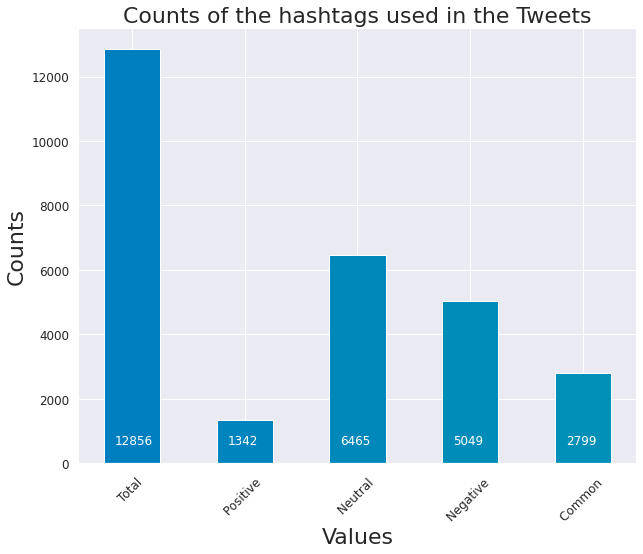

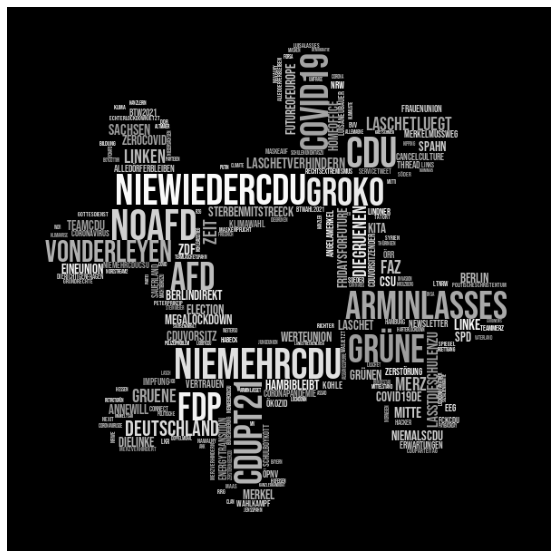

In [ ]:
common_hashtags = set(HT_positive+HT_neutral+HT_negative)

plot_freq_dist(HT_list,'Top 20 Hashtags used on the tweets',graph_output_file_path+"most_used_hashtags.png",n=20)
plot_freq_dist(HT_positive,'Top 20 Hashtags used on Positive sentiments',graph_output_file_path+"positive_hashtags.png",n=20)
plot_freq_dist(HT_neutral,'Top 20 Hashtags used on Neutral sentiments',graph_output_file_path+"neutral_hashtags.png",n=20)
plot_freq_dist(HT_negative,'Top 20 Hashtags used on Negative sentiments',graph_output_file_path+"negative_hashtags.png",n=20)

plot_hash_user_count(HT_list,HT_positive,HT_neutral,HT_negative,common_hashtags,graph_output_file_path+'hashtag_count.png',"Counts of the hashtags used in the Tweets")

masked_worldcloud_generate(common_hashtags,file_path='/content/drive/MyDrive/twitter_data/icons/slack-hash-brands.png',save_file_path=graph_output_file_path+'common_hashtag_wordcloud.png',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf',background='black',title='Common Hshtags on all the sentiments',color=grey_color_func)

#### Username - Positive, Neutral, Negative, Common hashtag 
1. Top 20 Usernames 
- Overall
- Positive
- Neutral 
- Negative
2. Usernames counts plot
3. Common usernames wordcloud

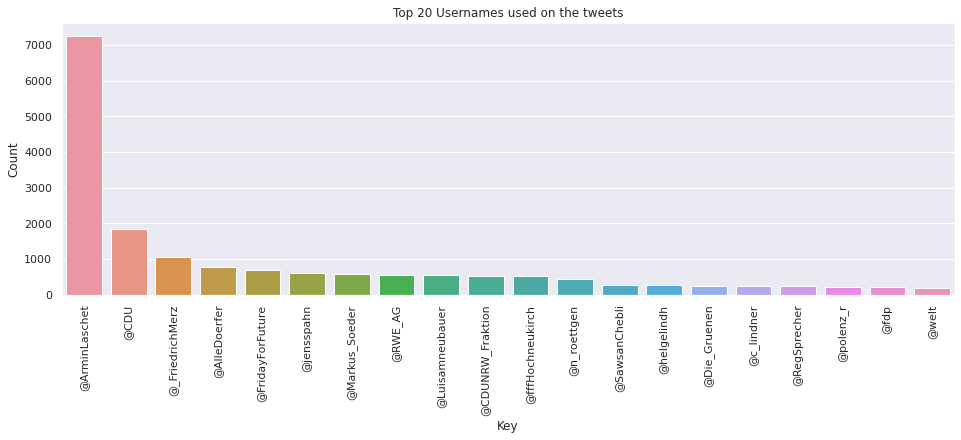

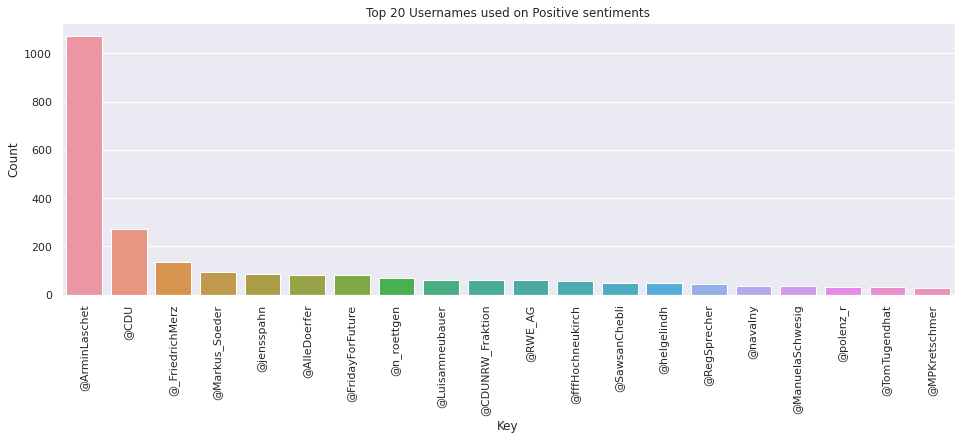

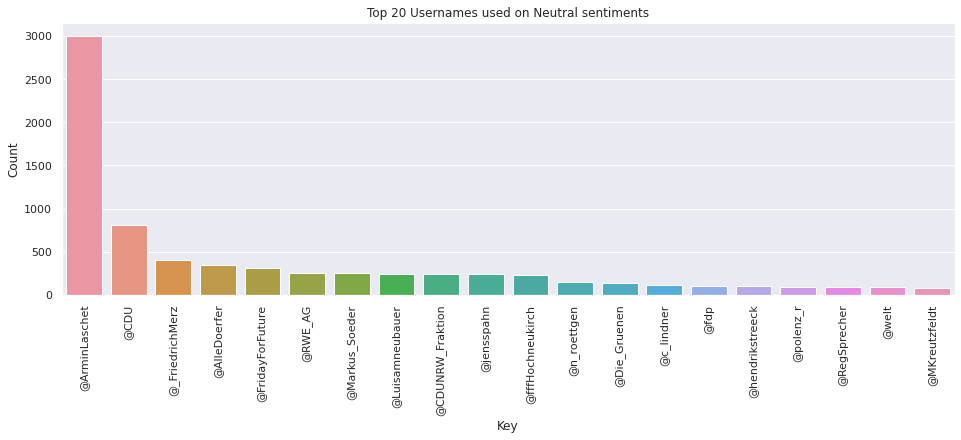

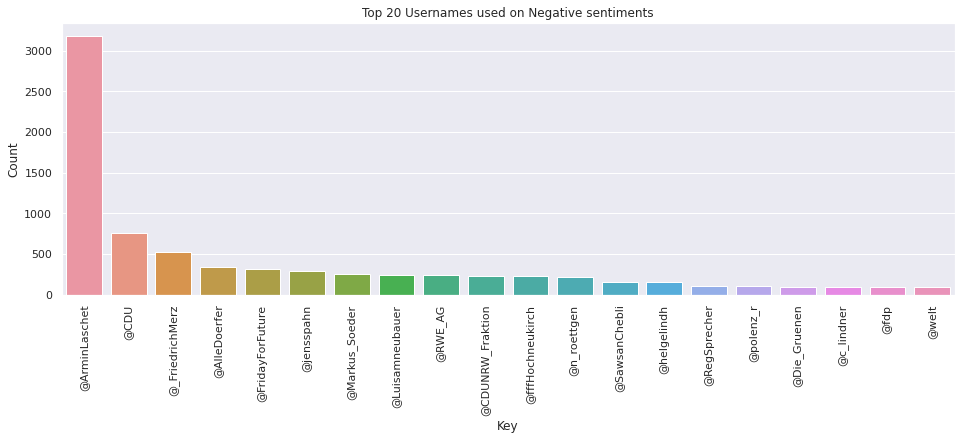

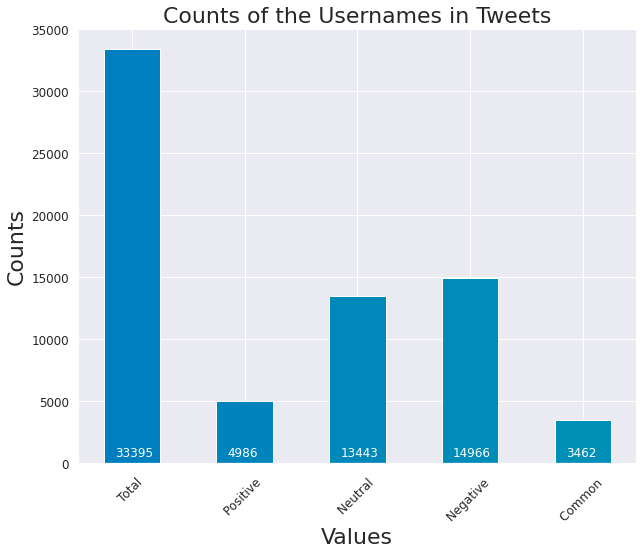

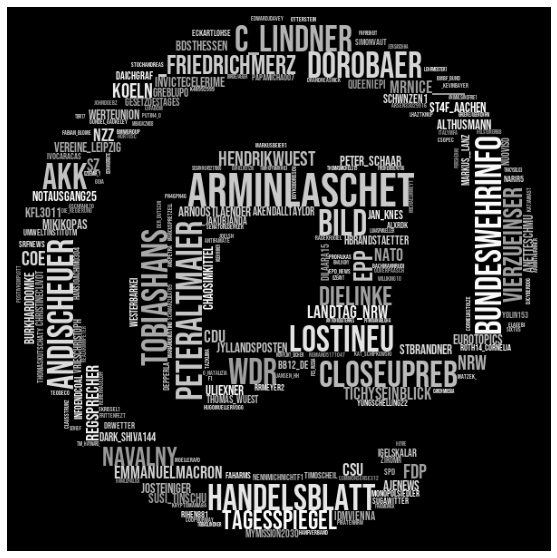

In [ ]:
common_usernames = set(UN_positive+UN_neutral+UN_negative)

plot_freq_dist(UN_list,'Top 20 Usernames used on the tweets',graph_output_file_path+"mostly_used_usernames.png",n=20)
plot_freq_dist(UN_positive,'Top 20 Usernames used on Positive sentiments',graph_output_file_path+"positive_usernames.png",n=20)
plot_freq_dist(UN_neutral,'Top 20 Usernames used on Neutral sentiments',graph_output_file_path+"positive_username.png",n=20)
plot_freq_dist(UN_negative,'Top 20 Usernames used on Negative sentiments',graph_output_file_path+"positive_usernames.png",n=20)

plot_hash_user_count(UN_list,UN_positive,UN_neutral,UN_negative,common_usernames,graph_output_file_path+'username_count.png','Counts of the Usernames in Tweets')

masked_worldcloud_generate(common_usernames,file_path='/content/drive/MyDrive/twitter_data/icons/at-solid.png',save_file_path=graph_output_file_path+'common_username_wordcloud.png',font_path='/content/drive/MyDrive/twitter_data/font/BebasNeue-Regular.ttf',background='black',title='Common Usernames on all the sentiments',color=grey_color_func)

#### Tweets and their retweets counts based on sentiments

In [ ]:
def plot_retweet_count(x_value,title,save_path_file):
    sns.countplot(x = x_value)
    plt.xlim(right=9)
    plt.title(title)
    plt.savefig(save_path_file)
    plt.show()

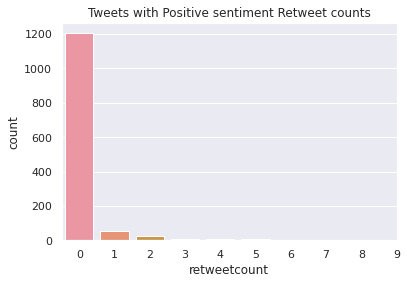

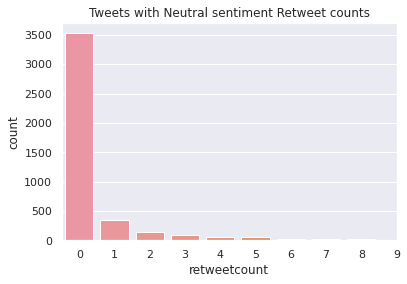

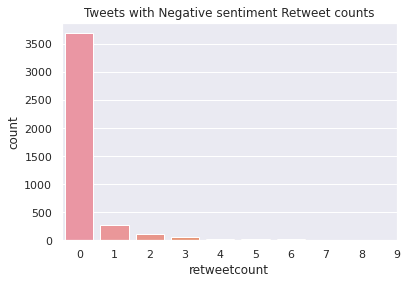

In [ ]:
plot_retweet_count(positive_retweets,'Tweets with Positive sentiment Retweet counts',graph_output_file_path+'positive_retweetcount.png')
plot_retweet_count(neutral_retweets,'Tweets with Neutral sentiment Retweet counts',graph_output_file_path+' neutral_retweetcount.png')
plot_retweet_count(negative_retweets,'Tweets with Negative sentiment Retweet counts',graph_output_file_path+'negative_retweetcount.png')


### User followers plot

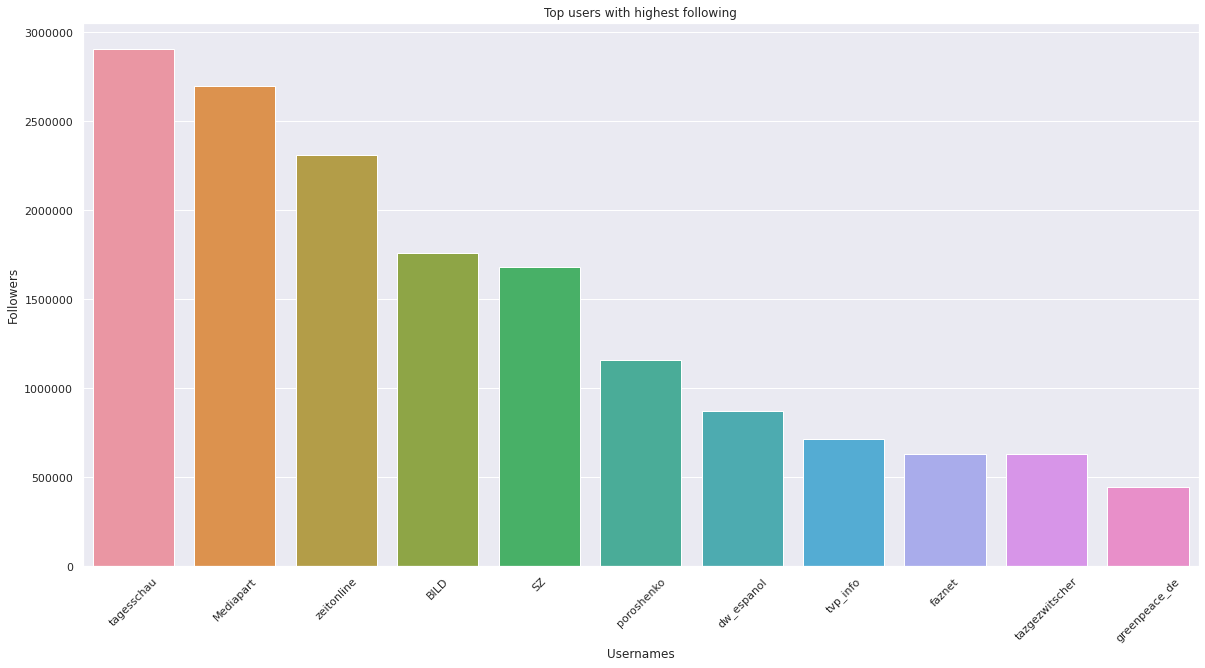

In [ ]:
# Users with more followers

user_df = political_df.sort_values(by=['followers','username'],ascending=False)
followers_list = list(user_df['followers'].iloc[:30])
username_list = list(user_df['username'].iloc[:30])
sentiments_list = list(user_df['sentiment'].iloc[:100])
colours = []
for i in sentiments_list:
    if i == 'positive':
        colours.append('green')
    elif i == 'neutral':
        colours.append('gray')
    else :
        colours.append('red')
plt.figure(figsize=(20,10))
ax = sns.barplot(x=username_list,y=followers_list)
plt.title('Top users with highest following')
plt.ticklabel_format(style='plain',axis='y')
plt.ylabel('Followers')
plt.xlabel('Usernames')
plt.xticks(rotation=45)
plt.savefig(graph_output_file_path+'top_users_follower.png')
plt.show()


#### Top users based on followers count and their tweet's sentiment
- Need to work on this

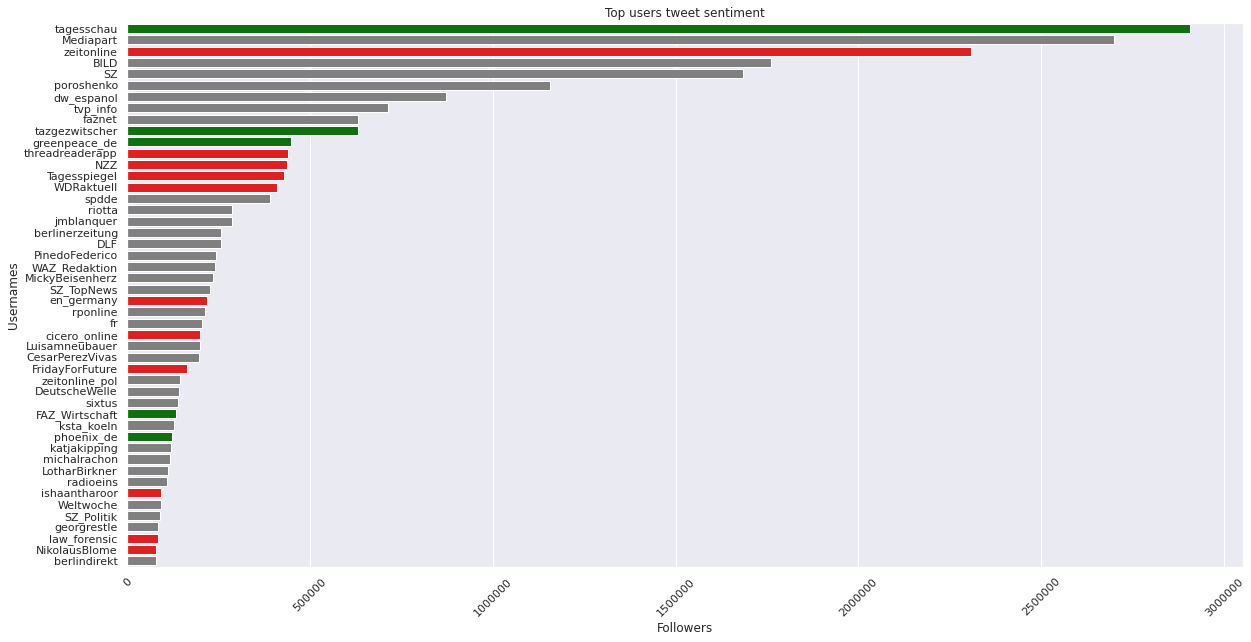

In [ ]:
colours = []
for i in sentiments_list:
    if i == 'positive':
        colours.append('green')
    elif i == 'neutral':
        colours.append('grey')
    else :
        colours.append('red')
plt.figure(figsize=(20,10))
sns.barplot(x = user_df['followers'].iloc[:100],y = user_df['username'].iloc[:100],palette=colours)
plt.title('Top users tweet sentiment')
plt.ticklabel_format(style='plain',axis='x')
plt.ylabel('Usernames')
plt.xlabel('Followers')
plt.xticks(rotation=45)
plt.show()